# Caso Everpeak - Analysis

In [1]:
# Importar pandas y cargar el archivo csv en un dataframe con el nombre df

import pandas as pd
df = pd.read_csv("/datasets/everpeak_retail.csv")

In [2]:
# Revisar qué columnas existen y qué tipos de datos contienen. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          5008 non-null   int64  
 1   order_date        5000 non-null   object 
 2   customer_id       5008 non-null   int64  
 3   product_category  5008 non-null   object 
 4   price             5008 non-null   int64  
 5   quantity          5008 non-null   int64  
 6   order_value       5008 non-null   int64  
 7   payment_method    5008 non-null   object 
 8   city              4908 non-null   object 
 9   state             4908 non-null   object 
 10  customer_age      4858 non-null   float64
dtypes: float64(1), int64(5), object(5)
memory usage: 430.5+ KB


In [3]:
# Antes de limpiar y analizar se hace una revisión general. 
# Detectar y sumar valores faltantes (missing) de las columnas payment_method, city y state.  

payment_missing = df["payment_method"].isna().sum()
city_missing = df["city"].isna().sum()
state_missing = df["state"].isna().sum()

print("payment_method missing:", payment_missing)
print("city missing:", city_missing)
print("state missing:", state_missing)


payment_method missing: 0
city missing: 100
state missing: 100


In [4]:
# Revisar fechas sospechosas y montos extremos. 

# Convertir la columna order_date a formato fecha, tratando los errores como valores faltantes. 
df["order_date"] = pd.to_datetime(df["order_date"],errors="coerce")

# Sumar cuántos registros tienen 2026 como año en order_date (Se trata de un error, pues no ha transcurrido el año)
invalid_year_2026_count = (df["order_date"].dt.year == 2026).sum()

# Sumar cuántos registros tienen order_date vacía después de la conversión 
missing_order_date_count = df["order_date"].isna().sum()

# Imprimir los conteos:
print("order_date año 2026:", invalid_year_2026_count)
print("order_date missing:", missing_order_date_count)


order_date año 2026: 15
order_date missing: 8


In [5]:
# Calcular la cardinalidad de columnas claves para entender si son IDs, categorías o variables poco útiles. 

# Calcular cuántos valores únicos hay en customer_id, customer_segment, city y state:

customer_id_unicos = df["customer_id"].nunique()
payment_unicos =  df["payment_method"].nunique()
city_unicos =  df["city"].nunique()
state_unicos =  df["state"].nunique()

# Imprimir cada resultado, mostrando los nombres de columna y el número de valores únicos: 

print("customer_id nunique:", customer_id_unicos)
print("payment_method nunique:", payment_unicos)
print("city nunique:", city_unicos)
print("state nunique:", state_unicos)


customer_id nunique: 1829
payment_method nunique: 4
city nunique: 10
state nunique: 9


In [6]:
# Detectar patrones de missingness por grupo (MCAR, MAR, MNAR)
# Evaluar si el missing de city depende de alguna variable de negocio, en este caso por payment_method.

# Crear la variable missing_city_by_pay que contenga el promedio de los missings agrupados según el payment_method
missing_city_by_pay = df["city"].isna().groupby(df["payment_method"]).mean()

# Imprimir los resultados:
print(missing_city_by_pay)



payment_method
cash           0.020101
credit_card    0.021517
debit_card     0.021300
paypal         0.015319
Name: city, dtype: float64


In [7]:
# Comparar impacto entre drop e imputación, para medir cómo cambia la métrica entre la imputación y la eliminación de datos. 

# Calcular la media original aquí (Antes de la imputación)
before = df["order_value"].dropna().mean()

# Código para imputar con la mediana
df["order_value_imputed"] = df["order_value"].fillna(df["order_value"]).median()

# calcula la media después de imputar
after = df["order_value_imputed"].mean()

# Imprimir los resultados para ver los efectos
print(before)
print(after)

10071.564696485622
10339.5


In [8]:
'''
Comparar el promedio original de customer_age contra los promedios después de hacer imputación con la mediana y la media,
para determinar cuál es la más apropiada para este caso.'''

# Guardar la media original, antes de cualquier imputación:
before = df["customer_age"].mean() 

# Crear "customer_age_med" para hacer la imputación con la mediana. 
df["customer_age_med"] = df["customer_age"].fillna(df["customer_age"]).median()
# Calcular el promedio con los datos imputados con la mediana:
after_med = df["customer_age_med"].mean()

# Crear "customer_age_mean" para hacer la imputación con la media.
df["customer_age_mean"] = df["customer_age"].fillna(df["customer_age"]).mean()
# calcula el promedio de los datos imputados con la media
after_mean = df["customer_age_mean"].mean()

# Imprimir los datos: 
print(before)
print(after_med)
print(after_mean)

# Se opta por la mediana, pues las edades no muestran una distribución normal (MAR)

43.72869493618773
49.0
43.728694936187715


In [9]:
''' 
Se crea la función "convertir_columnas_numericas(df, columnas)" que hace un ciclo for sobre las columnas
numéricas "columnas_numericas = ['price', 'quantity', 'order_value']" y las transforma a número, regresando el 
df ya con esas columnas modificadas. 
'''
def convertir_columnas_numericas(df, columnas):
    for col in columnas:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

# Se determinan las columnas numéricas:

columnas_numericas = ["price", "quantity", "order_value"]

# Se aplica la función al df
df = convertir_columnas_numericas(df, columnas_numericas)

# Se verifican los cambios:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   order_id             5008 non-null   int64         
 1   order_date           5000 non-null   datetime64[ns]
 2   customer_id          5008 non-null   int64         
 3   product_category     5008 non-null   object        
 4   price                5008 non-null   int64         
 5   quantity             5008 non-null   int64         
 6   order_value          5008 non-null   int64         
 7   payment_method       5008 non-null   object        
 8   city                 4908 non-null   object        
 9   state                4908 non-null   object        
 10  customer_age         4858 non-null   float64       
 11  order_value_imputed  5008 non-null   float64       
 12  customer_age_med     5008 non-null   float64       
 13  customer_age_mean    5008 non-nul

In [10]:
''' 
A fin de revisar la escalabilidad de la función, se agrega la columna de customer_id a la variable de 
"columnas_numéricas"
'''
columnas_numericas.append("customer_id")

# Se revisar nuevamente:

df = convertir_columnas_numericas(df, columnas_numericas)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   order_id             5008 non-null   int64         
 1   order_date           5000 non-null   datetime64[ns]
 2   customer_id          5008 non-null   int64         
 3   product_category     5008 non-null   object        
 4   price                5008 non-null   int64         
 5   quantity             5008 non-null   int64         
 6   order_value          5008 non-null   int64         
 7   payment_method       5008 non-null   object        
 8   city                 4908 non-null   object        
 9   state                4908 non-null   object        
 10  customer_age         4858 non-null   float64       
 11  order_value_imputed  5008 non-null   float64       
 12  customer_age_med     5008 non-null   float64       
 13  customer_age_mean    5008 non-nul

In [11]:
'''
Se comienza la revisión y corrección de las columnas categóricas. 
Se implementa un la función "step_strip_text(df)", para eliminar espacios inecesarios en las columnas:
"product_category", "city" y "state"
'''
def step_strip_text(df):
    #  Definir las columnas categóricas
    columnas = ["product_category", "city", "state"] 
    # Loop para aplicar strip() a cada columna
    for col in columnas:
        df[col] = df[col].str.strip()
        
    # Regresar df limpio
    return df

# Ejecutar para probar
df = step_strip_text(df)
print(df.head())

   order_id order_date  customer_id product_category  price  quantity  \
0         1 2024-02-02         2616           Sports    269        50   
1         2 2024-10-10         1736          Grocery     66         0   
2         3 2024-08-27         2543           Sports    267         0   
3         4 2024-06-09         2252             Toys    114       125   
4         5 2024-06-07         1583          Fashion    729        16   

   order_value payment_method         city state  customer_age  \
0        13385    credit_card     New York    NY          66.0   
1          660     debit_card  Los Angeles    CA          24.0   
2         5073    credit_card      Chicago    IL          23.0   
3        14290    credit_card     New York    NY          70.0   
4        11754    credit_card      Houston    TX          75.0   

   order_value_imputed  customer_age_med  customer_age_mean  
0              10339.5              49.0          43.728695  
1              10339.5              49.0

In [12]:
'''
Se está trabajando en las funciones que conformarán el pipeline central, que controlorá los pasos en el orden correcto: estandarizar texto --> 
convertir tipos --> tratar faltantes/inválidos.
En este punto, se crear una función que reemplace los "sentinels" en NaN
'''
def reemplazar_sentinels(df, sentinels):
    df["customer_age"] = df["customer_age"].replace(sentinels, pd.NA)
    return df
# observar valores ausentes iniciales
print("Valores ausentes", df["customer_age"].isna().sum())

# Fijar valores a corregir
valores_erroneos = [-999, 999, 0, -1] 

# Aplicar función, guardar resultados y observar cambios
df = reemplazar_sentinels(df, valores_erroneos) 
print("Valores ausentes", df["customer_age"].isna().sum())



Valores ausentes 150
Valores ausentes 175


In [13]:
'''
Se mejora la función con la implementación de un ciclo for que itera sobre la lista de "columnas numéricas"
'''
# Se agrega la entrada "numeric_cols" a la función y se le aumenta el ciclo for.  
def reemplazar_sentinels(df, sentinels, numeric_cols):
        # Ciclo for
    for columna in numeric_cols:
        df[columna] = df[columna].replace(sentinels, pd.NA)
    return df
# observar valores ausentes iniciales
print("Valores ausentes iniciales:")
print(df[["customer_age", "price"]].isna().sum())

# Fijar valores a corregir y columnas
valores_erroneos = [-999, 999, 0, -1]
columnas_numericas = ["customer_age", "price"] 

# Aplicar función y observar cambios
df = reemplazar_sentinels(df, valores_erroneos, columnas_numericas) 
print("\nValores ausentes después:")
print(df[["customer_age", "price"]].isna().sum())

Valores ausentes iniciales:
customer_age    175
price             0
dtype: int64

Valores ausentes después:
customer_age    175
price             2
dtype: int64


In [14]:
'''
Se crea una función que convierta columnas a tipo numérico y rellene los valores ausentes con el promedio.
'''
def rellenar_ausentes(df, cols_fill):
    # bucle para recorrer columnas
    for columna in cols_fill:
        # Convertir a numérico
        df[columna] =pd.to_numeric(df[columna], errors="coerce")
        # Rellenar con promedio usando inplace=True
        df[columna].fillna(df[columna].mean(),inplace=True) 
    return df

# observar valores ausentes iniciales
print("Valores ausentes iniciales:")
print(df[["customer_age", "price"]].isna().sum())

# Definir columnas a rellenar
columnas_rellenar = ["customer_age", "price"]  

# Aplicar función y observar cambios
df = rellenar_ausentes(df, columnas_rellenar) 
print("\nValores ausentes después:")
print(df[["customer_age", "price"]].isna().sum())

Valores ausentes iniciales:
customer_age    175
price             2
dtype: int64

Valores ausentes después:
customer_age    0
price           0
dtype: int64


In [15]:
'''
Crear la función pipeline que ejecute las funciones de limpieza en el orden correcto. 
'''
# Crear función pipeline
def limpiar_df(df):
    valores_erroneos = [-999, 999, 0, -1] # Definir valores_erroneos
    columnas_numericas = ["customer_age", "price"] # Definir columnas_numericas
    
    df = reemplazar_sentinels(df, valores_erroneos, columnas_numericas) # Aplicar reemplazar_sentinels
    df = rellenar_ausentes(df, columnas_numericas) # Aplicar rellenar_ausentes
    
    return df

# observar valores ausentes iniciales (Ya son cero, pues se trabajaron con anterioridad, pero se conserva hace la consulta)
print("Valores ausentes iniciales:")
print(df[["customer_age", "price"]].isna().sum())

# Aplicar pipeline completo
df = limpiar_df(df)
print("\nValores ausentes después del pipeline:")
print(df[["customer_age", "price"]].isna().sum())

Valores ausentes iniciales:
customer_age    0
price           0
dtype: int64

Valores ausentes después del pipeline:
customer_age    0
price           0
dtype: int64


In [16]:
'''
Resumen estadístico de las columnas numéricas, incluyendo tendencia central, variabilidad y valores extremos.
El equipo de Inteligencia Comercial necesita una visión rápida del desempeño de las categorías Fashion y Sports 
para entender su situación actual y detectar posibles anomalías en los datos.
Se carga el archivo al que se le aplicó el pipeline de limpieza. 
'''
df = pd.read_csv('/datasets/everpeak_clean.csv')

# Crear dataframes para cada categoría
df_fashion = df[df["product_category"] == "Fashion"]
df_sports = df[df["product_category"] == "Sports"]

# ------ Resumen de columnas numéricas con describe()
columnas_numericas = ['order_value', 'customer_age', 'price', 'quantity']

print('Resumen estadístico de la categoría Fashion')
print(df_fashion[columnas_numericas].describe()) 

print()#Salto de Línea
print('Resumen estadístico de la categoría Sports')
print(df_sports[columnas_numericas].describe())

Resumen estadístico de la categoría Fashion
         order_value  customer_age         price     quantity
count     739.000000    739.000000    739.000000   739.000000
mean     8745.139378     48.066306    585.863329    24.124493
std     10318.954880     18.083657    655.641761    72.380942
min       122.000000     18.000000     25.000000     1.000000
25%      2913.000000     32.000000    274.500000     8.000000
50%      8115.000000     47.000000    457.000000    14.000000
75%     12527.000000     64.000000    680.000000    21.000000
max    224884.000000     80.000000  11836.000000  1835.000000

Resumen estadístico de la categoría Sports
        order_value  customer_age        price    quantity
count    702.000000    702.000000   702.000000  702.000000
mean   10365.264957     49.742165   839.692308   21.099715
std     8820.536231     17.437736   848.292770   47.126458
min      195.000000     18.000000    47.000000    1.000000
25%     4308.750000     36.000000   347.000000    7.000000


In [17]:
'''
Comparar la media y la mediana de la columna order_value para evaluar si hay valores extremos influyendo en el análisis.
El equipo quiere entender si el gasto típico de los clientes que compran productos de supermercado está siendo afectado 
por outliers
'''
# Filtrar la categoría Grocery
df_grocery = df[df["product_category"] == "Grocery"] 

# Calcular media y mediana del gasto
promedio = df_grocery["order_value"].mean() 
mediana = df_grocery["order_value"].median()

# Mostrar resultados
print("Promedio del gasto en Grocery:", promedio)
print("Mediana del gasto en Grocery:", mediana)

# Interpretación según comparación de media y mediana
print("El promedio está afectado por outliers o valores atípicos en Grocery.")
# Hay una diferencia considerable entre la media y la mediana, por lo que se concluye que hay valores atípicos. 

Promedio del gasto en Grocery: 6943.137426900585
Mediana del gasto en Grocery: 4131.0
El promedio está afectado por outliers o valores atípicos en Grocery.


In [18]:
'''
Ahora se compara la  media y la mediana de la columna quantity para evaluar si los valores extremos
están afectando el análisis de la cantidad típica comprada por los clientes.
El equipo sospecha que existen outliers en la cantidad de productos comprados. 
'''
print("Promedio de quantity: ", df["quantity"].mean()) 
print("Mediana de quantity: ", df["quantity"].median() ) 
print("El promedio está afectado por los outliers o valores atípicos.")
# Como en el caso de Grocery, el promedio de quantity está afectado por valores atípicos.

Promedio de quantity:  32.3598
Mediana de quantity:  14.0
El promedio está afectado por los outliers o valores atípicos.


In [19]:
'''
Revisión del comportamiento de los clientes en las ciudades New York y Los Angeles, 
para comprender su situación actual y detectar posibles anomalías en los datos.
'''
# Crear dataframes para cada categoría
df_ny = df[df["city"] == "New York"] 
df_la = df[df["city"] == "Los Angeles"] 

# --- Resumen de columnas numéricas con describe()
columnas_numericas = ['order_value', 'customer_age', 'price', 'quantity']

print('Resumen estadístico de la ciudad New York')
print(df_ny[columnas_numericas].describe()) 

print()#Salto de Línea
print('Resumen estadístico de la ciudad Los Angeles')
print(df_la[columnas_numericas].describe())

Resumen estadístico de la ciudad New York
         order_value  customer_age         price     quantity
count     497.000000    497.000000    497.000000   497.000000
mean    10545.410463     49.847082    741.454728    40.800805
std     13914.329615     17.507624   1105.570500   147.484959
min        58.000000     18.000000     12.000000     1.000000
25%      2862.000000     35.000000    203.000000     8.000000
50%     10682.000000     49.000000    457.000000    14.000000
75%     13327.000000     64.000000    787.000000    24.000000
max    224884.000000     80.000000  11836.000000  2083.000000

Resumen estadístico de la ciudad Los Angeles
         order_value  customer_age         price     quantity
count     510.000000    510.000000    510.000000   510.000000
mean    10449.945098     49.741176    751.674510    39.511765
std     15979.195581     17.670518   1175.722235   128.503594
min        44.000000     18.000000     13.000000     1.000000
25%      3160.500000     35.000000    202.50

In [20]:
'''
Análisis estadístico de columnas categóricas. 
Revisar la distribución de los métodos de pago y las categorías de producto en Nueva York 
y Chicago para identificar patrones dominantes, diversidad de categorías y posibles anomalías.
'''
#  Columnas categóricas
columnas_categoricas = ['payment_method', 'product_category']

# Filtra por ciudad
df_ny = df[df["city"] == "New York"] 
df_chicago = df[df["city"] == "Chicago"] 

# Resumen categórico New York
print("Resumen categórico - New York")
print(df_ny[columnas_categoricas].describe()) 

print() # salto de línea

# Resumen categórico Chicago
print("Resumen categórico - Chicago")
print(df_chicago[columnas_categoricas].describe())

Resumen categórico - New York
       payment_method product_category
count             497              497
unique              4                8
top       credit_card             Toys
freq              271               76

Resumen categórico - Chicago
       payment_method product_category
count             482              482
unique              4                8
top       credit_card             Toys
freq              284               74


In [21]:
'''
Mediante un ciclo for, revisar todas las categorías de una columna junto con su frecuencia 
y calcular también los porcentajes.
'''
columnas_categoricas = ['product_category', 'payment_method', 'city', 'state']

# --- Distribución completa de columnas categóricas usando for
#completa el código aquí
for col in columnas_categoricas:
    print(col)
    print("Frecuencia absoluta")
    print(df[col].value_counts()) 
    print("Frecuencia relativa")
    print(df[col].value_counts(normalize=True)) 
    print() # Mantener un salto de línea

product_category
Frecuencia absoluta
Fashion        739
Electronics    735
Beauty         721
Toys           715
Sports         702
Grocery        684
Home           679
?               25
Name: product_category, dtype: int64
Frecuencia relativa
Fashion        0.1478
Electronics    0.1470
Beauty         0.1442
Toys           0.1430
Sports         0.1404
Grocery        0.1368
Home           0.1358
?              0.0050
Name: product_category, dtype: float64

payment_method
Frecuencia absoluta
credit_card    2737
paypal         1175
debit_card      889
cash            199
Name: payment_method, dtype: int64
Frecuencia relativa
credit_card    0.5474
paypal         0.2350
debit_card     0.1778
cash           0.0398
Name: payment_method, dtype: float64

city
Frecuencia absoluta
Houston          513
Seattle          513
Los Angeles      510
New York         497
Miami            493
Phoenix          491
Chicago          482
Boston           474
San Francisco    467
Denver           460
unknown

In [22]:
'''
Revisar la distribución de los métodos de pago y las ciudades asociadas a la categoría Toys, 
para identificar patrones dominantes, diversidad de ciudades y posibles anomalías.
'''
# Columnas categóricas
columnas_categoricas = ['payment_method', 'city']

# Filtra por categoría
df_toys = df[df["product_category"] == "Toys"] 

# Resumen categórico Toys
print("Resumen categórico - Toys")
print(df_toys[columnas_categoricas].describe())


Resumen categórico - Toys
       payment_method     city
count             715      715
unique              4       11
top       credit_card  Seattle
freq              383       81


In [23]:
'''
Revisar todas las ciudades asociadas a la categoría Sports, mostrando su frecuencia absoluta y su 
frecuencia relativa para entender la distribución de ubicaciones dentro de esta categoría.
'''
# Filtra por categoría
df_sports = df[df["product_category"] == "Sports"] 

# Distribución de city
print("Frecuencia absoluta")
print(df_sports["city"].value_counts())
print("\nFrecuencia relativa")
print(df_sports["city"].value_counts(normalize=True))


Frecuencia absoluta
San Francisco    85
Los Angeles      84
New York         74
Miami            74
Denver           68
Seattle          67
Boston           66
Chicago          60
Houston          59
Phoenix          55
unknown          10
Name: city, dtype: int64

Frecuencia relativa
San Francisco    0.121083
Los Angeles      0.119658
New York         0.105413
Miami            0.105413
Denver           0.096866
Seattle          0.095442
Boston           0.094017
Chicago          0.085470
Houston          0.084046
Phoenix          0.078348
unknown          0.014245
Name: city, dtype: float64


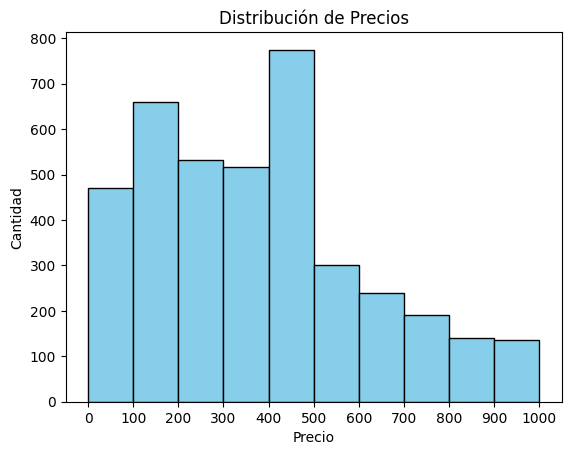

In [25]:
'''
Mediante un histograma, cómo se distribuyen los precios y detectar posibles valores atípicos que puedan 
afectar los análisis.
'''
# Importar la librería de matplotlib, para hacer el histograma. 
import matplotlib.pyplot as plt

# Graficar histograma
counts, bin_edges, _ = plt.hist(df["price"], bins=10, range=(0,1000), color='skyblue', edgecolor='black') 

# Mostrar las marcas de los bins en el eje X
plt.xticks(bin_edges)

# Etiquetas y título del gráfico
plt.xlabel("Precio")
plt.ylabel("Cantidad")
plt.title("Distribución de Precios")
plt.show()

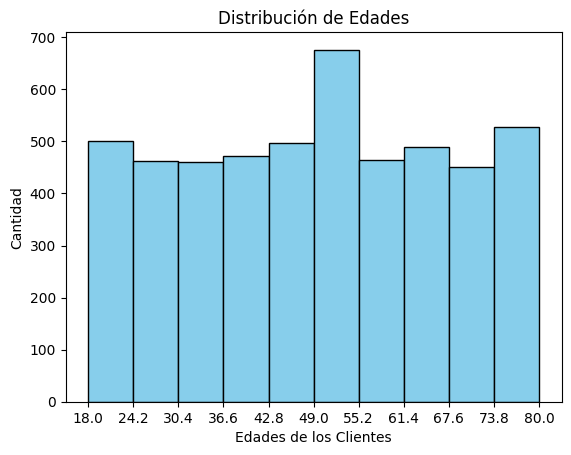

In [26]:
'''
Mediante un histograma, revisar la distribución de las edades de los clientes (customer_age) para 
segmentar mejor las estrategias de marketing.
'''
# Graficar histograma
counts, bin_edges, _ = plt.hist(df['customer_age'], bins=10, color='skyblue', edgecolor='black') 

# Mostrar las marcas de los bins en el eje X
plt.xticks(bin_edges)

# Etiquetas y título del gráfico
plt.title("Distribución de Edades")
plt.xlabel("Edades de los Clientes") 
plt.ylabel("Cantidad")
plt.show()


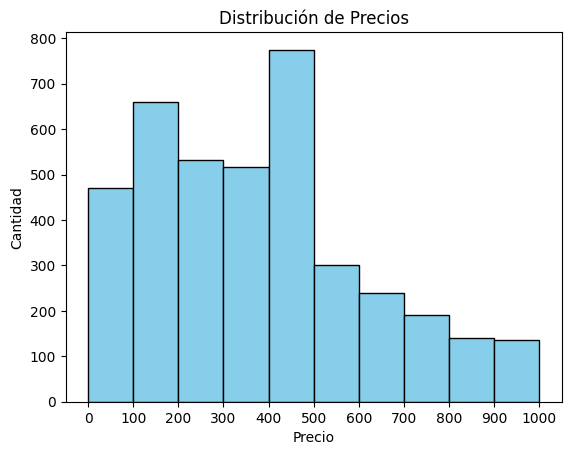

In [27]:
'''
Mediante un histograma, revisar cómo se distribuyen los precios y detectar posibles valores atípicos que puedan 
afectar los análisis.
'''
# Graficar histograma
counts, bin_edges, _ = plt.hist(df["price"], bins = 10, range = (0,1000), color = 'skyblue', edgecolor = 'black' )

# Mostrar las marcas de los bins en el eje X
plt.xticks(bin_edges)

# Etiquetas y título del gráfico
plt.xlabel("Precio")
plt.ylabel("Cantidad")
plt.title("Distribución de Precios")
plt.show()


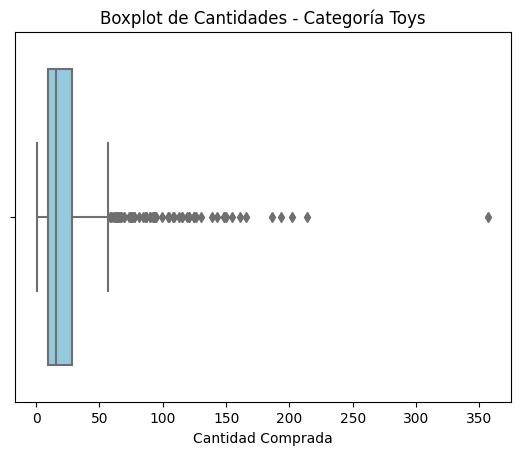

In [28]:
'''
Graficar un boxplot para analizar cómo se distribuyen las cantidades compradas (quantity) dentro de la categoría 
"Toys", para detectar valores extremos que podrían afectar decisiones de inventario y logística.
'''
# Importar la librería de seaborn
import seaborn as sns

# Filtrar por categoría "Toys"
df_toys = df[df['product_category'] == "Toys"] 

# Graficar BoxPlot
sns.boxplot(df_toys["quantity"], color = 'skyblue' )

# Etiquetas y título del gráfico
plt.title("Boxplot de Cantidades - Categoría Toys")
plt.xlabel("Cantidad Comprada")
plt.show()


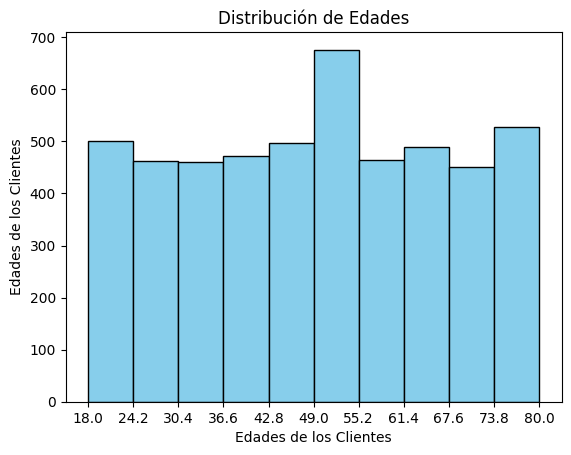

In [29]:
'''
Revisar mendiante un histograma la distribución de las edades de los clientes (customer_age) 
para segmentar mejor las estrategias de marketing
'''
# Graficar histograma
counts, bin_edges, _ = plt.hist(df['customer_age'], bins = 10, color = 'skyblue', edgecolor = 'black')

# Mostrar las marcas de los bins en el eje X
plt.xticks(bin_edges)
# Etiquetas y título del gráfico
plt.xlabel("Edades de los Clientes")
plt.ylabel("Edades de los Clientes") 
plt.title("Distribución de Edades") 
plt.show()

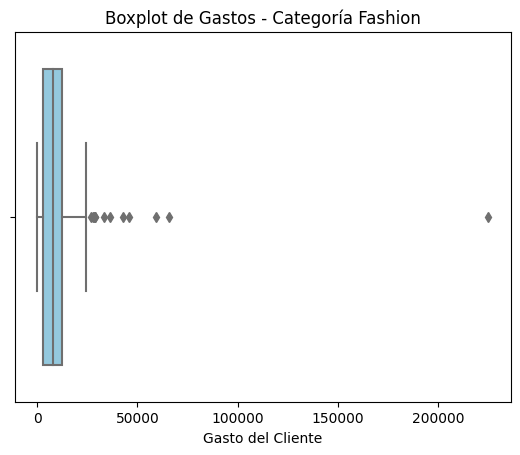

In [31]:
'''
Graficar un boxplot que muestre cuánto gastan los clientes en las categorías “Fashion” y “Sports”, 
evaluando la dispersión del order_value y detectando posibles outliers que puedan afectar decisiones 
de negocio.
'''
# Filtrar datos
df_fashion = df[df["product_category"] == "Fashion"] 
df_sports = df[df["product_category"] == "Sports"]

# BoxPlot Categoría Fashion
sns.boxplot(df_fashion["order_value"], color = 'skyblue') 
plt.xlabel("Gasto del Cliente") 
plt.title("Boxplot de Gastos - Categoría Fashion")
plt.show()

In [33]:
'''
Ahora se procede a identificar valores atípicos mediante reglas estadísticas.
Identificar outliers en order_value con IQR.
'''
# calcular Q1, Q3 e IQR
Q1 = df['order_value'].quantile(0.25) 
Q3 = df['order_value'].quantile(0.75) 
IQR = Q3 - Q1 

# calcular límite inferior y superior
limite_inferior = Q1 - 1.5 * IQR  
limite_superior = Q3 + 1.5 * IQR 

# Mostrar resultados
print('Primer cuartil: ', Q1)
print('Tercer cuartil: ', Q3)
print('IQR: ', IQR)

print("\nRegistros abajo del límite inferior")
print(df[df['order_value'] < limite_inferior]) 

print("\nRegistros arriba del límite superior")
print(df[df['order_value'] > limite_superior])

Primer cuartil:  3094.0
Tercer cuartil:  13160.5
IQR:  10066.5

Registros abajo del límite inferior
Empty DataFrame
Columns: [order_id, order_date, customer_id, product_category, price, quantity, order_value, payment_method, city, state, customer_age, quantity_invalid_flag, age_invalid_flag, state_missing_flag, z]
Index: []

Registros arriba del límite superior
      order_id  order_date  customer_id product_category  price  quantity  \
8            9  2024-03-14         2925           Beauty     55       833   
123        124  2024-06-21         1389      Electronics   1947        16   
155        156  2024-08-30         2901          Grocery     36      1278   
199        200  2024-12-18         2919          Fashion   5174         7   
265        266  2024-07-31         1905      Electronics   2897        10   
...        ...         ...          ...              ...    ...       ...   
4934      4935  2024-05-19         1502      Electronics   4282        11   
4936      4937  2024

In [34]:
'''
Identificar outliers en order_value usando Z-Score.
'''
#cálculo de la media
mean = df['order_value'].mean()

#cálculo de la desviación estándar
std = df['order_value'].std()

#Crea el z score
df['z'] = (df['order_value'] - mean) / std 

#Calcula los valores extremos
print(df[df['z'].abs()>3])

      order_id  order_date  customer_id product_category  price  quantity  \
293        294  2024-05-01         2149      Electronics   3336        17   
369        370  2024-10-09         2784      Electronics   5973        13   
375        376  2024-02-04         2285      Electronics   4782        20   
391        392  2024-03-06         2981      Electronics   2463        20   
397        398  2024-03-12         2024      Electronics   4893        18   
...        ...         ...          ...              ...    ...       ...   
4698      4699  2024-04-20         2059      Electronics   5227        11   
4732      4733  2024-10-06         2685           Sports   3394        14   
4908      4909  2024-10-19         1119      Electronics   3927        19   
4921      4922  2024-11-15         1621           Sports   2765        18   
4942      4943  2024-11-02         1979      Electronics   6478        11   

      order_value payment_method      city    state  customer_age  \
293   

In [35]:
'''
Comparar métodos IQR y Z-Score en la columna price
'''
# ----- IQR -----
# calcular Q1, Q3 e IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# calcular límite inferior y superior
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# ----- Z-score -----
# calcular media, desviación estándar y z-score
mean = df['price'].mean()
std = df['price'].std()
df['z'] = (df['price'] - mean) / std 

# ----- Mostrar resultados -----
print('Outliers usando IQR:')
print(df[(df['price'] < lower)  | (df['price'] > upper)]) 

print('\nOutliers usando Z-Score:')
print(df[df['z'].abs()>3])

Outliers usando IQR:
      order_id  order_date  customer_id product_category  price  quantity  \
64          65  2024-05-30         1651           Sports   2106         5   
67          68  2024-05-15         2385             Home   5181         4   
95          96  2024-04-15         2991           Sports   1940         4   
123        124  2024-06-21         1389      Electronics   1947        16   
138        139  2024-05-07         2274      Electronics   2437         6   
...        ...         ...          ...              ...    ...       ...   
4955      4956  2024-03-11         2230      Electronics   3824         6   
4974      4975  2024-10-20         2627      Electronics   1985         6   
4984      4985  2024-03-11         2509           Sports   1911         4   
4990      4991  2024-08-25         2569           Sports   2856         5   
4997      4998  2024-10-26         2838      Electronics   2699         4   

      order_value payment_method         city    state

In [36]:
'''
Crear una regla que indique si los clientes en general superan cierto volumen de compra.
'''
# Calcular promedio y mediana
cantidad_promedio = df['quantity'].mean() 
cantidad_mediana = df['quantity'].median() 
print("Promedio:", cantidad_promedio)
print("Mediana:",cantidad_mediana)
print() # salto de línea

# Segmentación con media o promedio
if cantidad_promedio > 22: 
    print("En promedio: volumen alto") 
else: 
    print("En promedio: volumen bajo") 

# Segmentación con mediana
if cantidad_mediana > 22:
    print("Según la mediana: volumen alto")
else:
    print("Según la mediana: volumen bajo")

Promedio: 32.3598
Mediana: 14.0

En promedio: volumen alto
Según la mediana: volumen bajo


In [37]:
'''
Mejorar la regla anterior agregando una tercera categoría.
'''
# Segmentación con media o promedio
if cantidad_promedio > 22:
    print("En promedio: volumen alto")
elif cantidad_promedio >= 10:
    print("En promedio: volumen medio")
else: 
    print("En promedio: volumen bajo")
    
# Segmentación con mediana
if cantidad_mediana > 22:
    print("Según la mediana: volumen alto")
elif cantidad_mediana >= 10: 
    print("Según la mediana: volumen medio")
else: 
    print("Según la mediana: volumen bajo")

En promedio: volumen alto
Según la mediana: volumen medio


In [38]:
'''
Segmentar a los clientes por volumen de compra, determinando "High volume" o "Low Volume"
'''
# Se importa la librería de numpy:
import numpy as np

# Crear columna nueva
df["volume_segment"] = np.where(df['quantity'] > 22, "High Volume", "Low Volume")

# Verificar cambios
print(df['volume_segment'].value_counts())

Low Volume     3739
High Volume    1261
Name: volume_segment, dtype: int64


In [39]:
'''
Segmentar los clientes por edad y por volumen de compra, separando en 4 segmentos.
Se previene contra la existencia de nulos o faltantes.
'''
def classify_volume(row):
    age = row['customer_age'] # extrae la edad
    qty = row['quantity'] # extrae la cantidad de compra

    # 1. Manejo de valores nulos/faltantes
    # pd.isna() verifica de forma robusta si el valor es NaN
    if pd.isna(age) or pd.isna(qty):
        return "Error en Datos"

    # --- 2. Segmentación de Altas Cantidades ---
    if qty > 22:
        if age > 55: # Revisar edad mayor a 55 años
            return "Sr. High Volume" 
        else: # age <= 55
            return "Jr. High Volume" 
            
    # --- 3. Segmentación Bajas Cantidades ---
    elif qty <= 22: # Revisar cantidad menor o igual a 22
        if age > 55: # Revisar edad mayor a 55 años
            return "Sr. Low Volume" 
        else: # age < 55
            return "Jr. Low Volume" 

# aplicar función y verificar cambios
df["volume_segment"] = df.apply(classify_volume, axis=1) 
print(df['volume_segment'].value_counts())


Jr. Low Volume     3004
Sr. High Volume    1197
Sr. Low Volume      735
Jr. High Volume      64
Name: volume_segment, dtype: int64


In [40]:
'''
Segmentar las transacciones según el método de pago y el volumen de compra, para analizar 
patrones de pago en compras altas y bajas.
Se previene contra la existencia de nulos o faltantes. 
'''
def classify_payment(row):
    card = row['payment_method'] 
    qty = row['quantity'] 

    # 1. Manejo de valores nulos/faltantes
    if pd.isna(card) or pd.isna(qty):
        return "Error en Datos"

    # --- 2. Segmentación de Altas Cantidades ---
    if qty > 22:
        if card == 'credit_card' or card == 'debit_card': 
            return  "card_high_volume"
        else: 
            return "no_card_high_volume" 
            
    # --- 3. Segmentación Bajas Cantidades ---
    elif qty <= 22:
        if card == 'credit_card' or card == 'debit_card':  
            return "card_low_volume" 
        else: 
            return "no_card_low_volume" 

# aplicar función y verificar cambios
df['payment_segment'] = df.apply(classify_payment, axis=1)  
print(df['payment_segment'].value_counts())

card_low_volume        2704
no_card_low_volume     1035
card_high_volume        922
no_card_high_volume     339
Name: payment_segment, dtype: int64
